### Setup

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder, LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, cross_val_predict, learning_curve
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Import

In [7]:
# Load full data set
f = 'loan_clean.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    data = pickle.load(file)

In [8]:
# Load train set
f = 'loan_train.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    train = pickle.load(file)

In [9]:
# Load test set
f = 'loan_test.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    test = pickle.load(file)

In [10]:
train.shape[0], test.shape[0]

(163306, 40827)

### Data Preperation

In [2]:
# Class for selecting attributes from a dataframe, for use in pipelines

class DataFrame_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names

In [3]:
# Converts categorical columns into OHE columns
class DataFrame_DummyEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names, valid_dummy_cols=None):
        self.attribute_names = attribute_names
        # In case categorical values differ between datasets
        self.valid_dummy_cols = valid_dummy_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.valid_dummy_cols is not None:
            zero_data = np.zeros(shape=(len(X),len(self.valid_dummy_cols)))
            self.dummies = pd.DataFrame(zero_data, columns=valid_dummy_cols)
            d = pd.get_dummies(X[self.attribute_names])

            for col in d.columns:
                if col in self.dummies.columns:
                    self.dummies[col] = d[col].values
        else:
            self.dummies = pd.get_dummies(X[self.attribute_names])
        return self.dummies.values
    
    def get_feature_names(self):
        return self.dummies.columns.tolist()

In [4]:
# Creates custom numerical attributes (just grade and subgrade for the time being)
class CustomNumAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        grade_map = {grade: i for i, grade in enumerate('ABCDEFG')}
        subgrade_map = {sg: grade_map[sg[0]]*10 + int(sg[1]) for sg in [c + str(i) for c in 'ABCDEFG' for i in range(1,6)]}
        # Note: following assumes that X is still be a pandas DataFrame vs. numpy array.
        X['grade_vals'] = X['grade'].map(grade_map)
        X['subgrade_vals'] = X['sub_grade'].map(subgrade_map)
        return X
    def get_feature_names(self):
        return X.columns.tolist()

In [14]:
# Default set of columns without any feature selection
num_attr = ['funded_amnt', 'installment', 'annual_inc_merged', 'dti_merged', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collection_recovery_fee', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'total_rev_hi_lim', 'tot_cur_bal', 'tot_coll_amt', 'grade_vals', 'subgrade_vals']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record']

cat_attr = ['emp_length', 'purpose', 'home_ownership', 'verification_status_merged', 'application_type', 'term']

In [15]:
# Get list of valid dummy columns from full data set
valid_dummy_cols = pd.get_dummies(data[cat_attr]).columns

In [16]:
num_prep = Pipeline([('add_custom', CustomNumAttributes()),
                     ('select', DataFrame_Selector(num_attr)),
                     ('sc', StandardScaler())])

bin_prep = Pipeline([('select', DataFrame_Selector(bin_attr))])

cat_prep = Pipeline([('encode', DataFrame_DummyEncoder(cat_attr, valid_dummy_cols))])

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

### Feature Selection

For the purpose of this MVP analysis and setting some basic benchmarks for comparison with more in-depth models, feature selection will be limited to the standard attributes, with the sole exception being the grade conversion conducted during EDA:

In [46]:
# Create mapping functions to return numeric value for a grade...

def grade_val(grade, grade_map=None):
    if grade_map is None:
        # A = 0, B = 1, ..., G = 6
        grade_map = {c: i for i, c in enumerate('ABCDEFG')}
    
    try:
        val = grade_map[grade]
    except:
        val = np.NaN
    
    return val

def subgrade_val(subgrade, subgrade_map=None):
    if subgrade_map is None:
        # A1 = 1, A2 = 2, ..., G4 = 64, G5 = 65
        subgrade_map = {sg: grade_dict[sg[0]]*10 + int(sg[1]) for sg in [c + str(i) for c in 'ABCDEFG' for i in range(1,6)]}
    
    try:
        val = subgrade_map[subgrade]
    except:
        val = np.NaN
        
    return val

In [47]:
grade_map = {c: i for i, c in enumerate('ABCDEFG')}
subgrade_map = {sg: grade_map[sg[0]]*10 + int(sg[1]) for sg in [c + str(i) for c in 'ABCDEFG' for i in range(1,6)]}

train['grade_value'] = train['grade'].apply(lambda x: grade_val(x, grade_map))
train['subgrade_value'] = train['sub_grade'].apply(lambda x: subgrade_val(x, subgrade_map))

Taking a quick look at the correlation matrix for problematic attributes:

In [48]:
# Columns which capture future-known values we would not have access to at the time a loan is issued
ignore_cols = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_late_fee',
               'total_rec_int','recoveries', 'last_pymnt_amnt', 'loan_p_return']

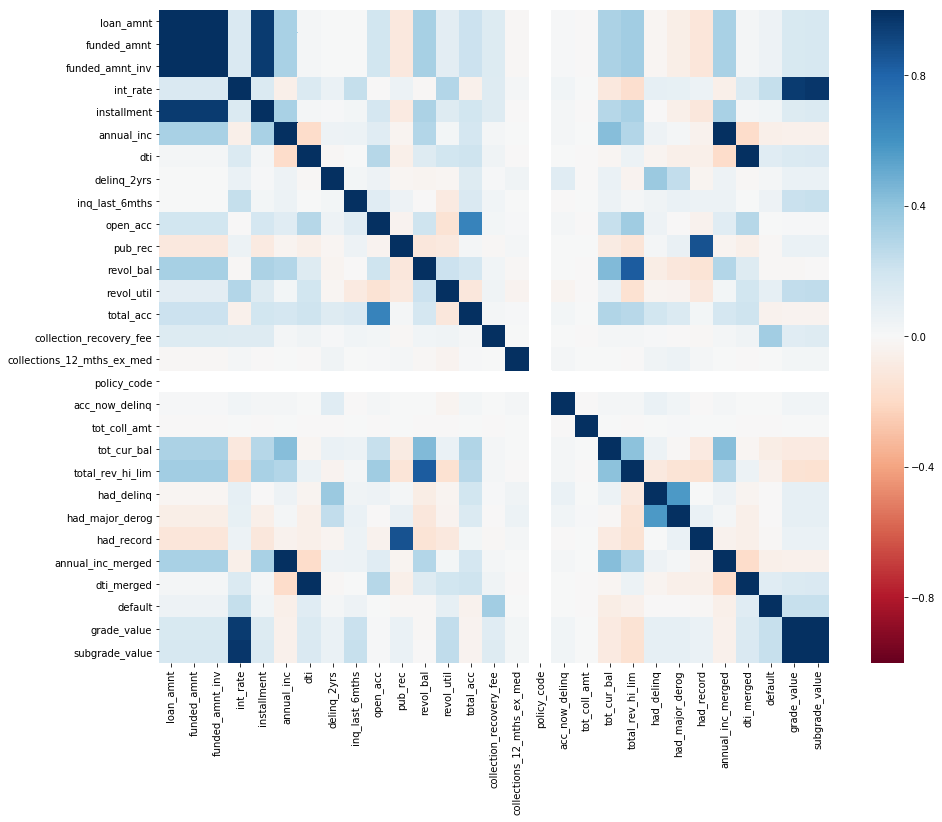

In [49]:
plt.figure(figsize=(15,12))
sns.heatmap(train.drop(ignore_cols, axis=1).corr(), cmap='RdBu', vmin=-1, vmax=1)
plt.show()

Taking the correlations above into account and the conclusions reached during EDA, basic feature selection will involve the following:

- Ignore features that are directly correlated. For example, between grades and interest rates only one should be selected.
- Ignore features that capture future information. For example, payment dates, total payment, total received late fees, etc.
- Ignore features that are redundant. For example, selecting only one from loan amount, funded amount and funded amount invested, which essentially capture the same value.

This leaves us with the following columns:

In [5]:
# Numerical
num_attr = ['funded_amnt', 'installment', 'annual_inc_merged', 'dti_merged', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collection_recovery_fee', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'total_rev_hi_lim', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_vals']
# Binary
bin_attr = ['had_delinq', 'had_major_derog', 'had_record']

# Categorical
cat_attr = ['emp_length', 'purpose', 'home_ownership', 'verification_status_merged', 'application_type', 'term']

Note that subgrade was selected over regular grade in the list of numerical attributes due to it being more specific.

In [6]:
# Load full train set
f = 'loan_clean_v2.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    data = pickle.load(file)

In [7]:
# Get list of valid dummy columns from full data set
valid_dummy_cols = pd.get_dummies(data[cat_attr]).columns

In [8]:
num_prep = Pipeline([('add_custom', CustomNumAttributes()),
                     ('select', DataFrame_Selector(num_attr)),
                     ('sc', StandardScaler())])

bin_prep = Pipeline([('select', DataFrame_Selector(bin_attr))])

cat_prep = Pipeline([('encode', DataFrame_DummyEncoder(cat_attr, valid_dummy_cols))])

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [9]:
# Load full train set
f = 'loan_default_train.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    train = pickle.load(file)

In [10]:
# Load full train set
f = 'loan_default_test.p'
d = ['..', 'data', 'interim']
fp = path.join(*d, f)

with open(fp, 'rb') as file:
    test = pickle.load(file)

In [11]:
X_train = feature_prep.fit_transform(train)
y_train = train['default']

X_test = feature_prep.fit_transform(test)
y_test = test['default']

### Modeling

##### Setup

In [57]:
# Initialize dict for models
models = {}

In [19]:
# Function to plot PR curve
def plot_pr_curve(model, X, y, label=None, cv=3, n_jobs=1):
    if hasattr(model, 'decision_function'):
        y_scores = cross_val_predict(model, X, y, cv=cv, method='decision_function', n_jobs=n_jobs)[:,1]
    else:
        y_scores = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=n_jobs)[:,1]
    
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    fig, axs = plt.subplots(1,2,figsize=(15,7))

    axs[0].plot(thresholds, precisions[:-1], 'b--', label='Precision')
    axs[0].plot(thresholds, recalls[:-1], 'g-', label='Recall')
    x_min = max(thresholds[(len(recalls) - np.argmax(recalls[::-1][:-1]) -1)]*1.1, min(thresholds))
    x_max = min(thresholds[np.argmax(precisions[:-1])]*1.1, max(thresholds))
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_xlabel('Decision Threshold')
    axs[0].set_ylabel('Precision / Recall')
    axs[0].legend()

    axs[1].plot(recalls[:-1], precisions[:-1], 'r-')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')

    plt.suptitle('Precision/Recall Curve{}'.format(': ' + str(label) if label is not None else ''))

    plt.show()
    
    return precisions, recalls, thresholds

In [20]:
def plot_learning_curve(estimator, X, y, scoring=None, train_sizes=[0.1, 0.325, 0.55 , 0.775, 1.], cv=None, random_state=None, n_jobs=1, figsize=(10,5), xlim=None, ylim=None, title=None, subplots=False):
    
    scoring = list(scoring)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    if subplots:
            fig, axs = plt.subplots(len(scoring),1, figsize=figsize)
    else:
        axs = [plt.figure(figsize=figsize).gca()] * len(scoring)
          
    for i, (score, ax) in enumerate(zip(scoring, axs)):
        try:
            lc = learning_curve(estimator=estimator, X=X, y=y, train_sizes=train_sizes, scoring=score, cv=cv, random_state=random_state, n_jobs=n_jobs)
            ax.plot(lc[0], np.mean(lc[1], axis=1), label='Train ({})'.format(score.title()), ls='--', alpha=0.5, color=colors[i], lw=2)
            ax.plot(lc[0], np.mean(lc[2], axis=1), label='Validate ({})'.format(score.title()), color=colors[i], lw=2)
            
            if xlim is not None:
                ax.xlim(xlim)
            if ylim is not None:
                ax.ylim(ylim)
            
            ax.set_xlabel('Samples')
            ax.set_ylabel('Score')
            ax.legend(bbox_to_anchor=(1,1))
            ax.set_title('Learning Curve: {}'.format(score.title() if subplots else ', '.join(scoring).title()))
            
        except Exception as e:
            print(e)
    
    if title is not None:
        plt.suptitle(title)
    
    plt.tight_layout()
    plt.show()   

In [1]:
def classifier_summary(y_actual, y_pred, print_results=True): 
    
    f1 = f1_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    
    conf_mat = confusion_matrix(y_actual, y_pred)
    
    specificity = conf_mat[0,0] / (conf_mat[0,:].sum())
    fallout = 1 - specificity
    precision_neg = conf_mat[0,0] / (conf_mat[:,0].sum())
    
    df_cmat = pd.DataFrame(conf_mat).rename(index={0:'Actual Negative', 1:'Actual Positive'},
                                  columns={0:'Predicted Negative', 1:'Predicted Positive'})
    
    df_scores = pd.DataFrame([{'Rate': 'f1', 'Score': f1},
                              {'Rate': 'Recall', 'Score': recall},
                              {'Rate': 'Precision (pos)', 'Score': precision},
                              {'Rate': 'Precision (neg)', 'Score': precision_neg},
                              {'Rate': 'Specificity', 'Score': specificity},
                              {'Rate': 'Fallout', 'Score': fallout}]).set_index('Rate')
    
    if print_results:
        print('Confusion Matrix:')
        print(df_cmat)
        print(20*'-')
        print('Accuracy Scores:')
        print(df_scores)
   
    return df_cmat, df_scores

In [2]:
def plot_gs_param(gs, set_xscale=False, set_ylim=False, val_label=True, figsize=(12,12)):
    
    if len(gs.param_grid) > 1:
        print('Error: grid search contains more than one parameter. Function only compatible with single parameter grid searches.')
        return None
    
    param = list(logreg_C_gs.param_grid.keys())[0]
    
    plt.figure(figsize=figsize)
    plt.title("GridSearchCV Scores for Parameter {}".format(param), fontsize=16)

    plt.xlabel(param)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    if set_xscale:
        ax.set_xscale(set_xscale)
    if set_ylim:
        ax.set_ylim(set_ylim)
    
    results = gs.cv_results_

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_' + param].data, dtype=float)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, scorer in enumerate(sorted(scoring)):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=colors[i])
            ax.plot(X_axis, sample_score_mean, style, color=colors[i],
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, 'val' if (val_label and sample=='test') else sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=colors[i], marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))
    
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid('off')
    plt.show()

##### Measuring Accuracy

The business problem at hand for this classification problem is to identify loans that will default. In terms of measuring the performance of our models, the question arises as to which method of scoring / accuracy we value most. In the context of investing in loans, the risks and consequences of failing to identify a default loan greatly outweight those of accidentally discarding some quality loans as default. Consequently, whilst we will use f1 scoring as a reference, maximizing recall (proportion of defaulted loans correctly identified) should be the priority.

##### Logistic Regression


Basic model, no tuning:

In [61]:
logreg = LogisticRegression()

logreg_timeit = %timeit -n1 -r1 -o \
logreg.fit(X_train, y_train)

5.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Not a bad fit time with 10 seconds. Let's see how the base model performs with cross validation scores (f1 and recall):

In [62]:
logreg_f1_cvs = cross_val_score(estimator=logreg,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             scoring='f1',
                             n_jobs=4)

In [63]:
logreg_recall_cvs = cross_val_score(estimator=logreg,
                                     X=X_train,
                                     y=y_train,
                                     cv=5,
                                     scoring='recall',
                                     n_jobs=4)

In [66]:
# Test scoring on harsh set
print('CV mean train f1 score = {:.3f}'.format(logreg_f1_cvs.mean()))
print('CV mean train recall score = {:.3f}'.format(logreg_recall_cvs.mean()))

CV mean train f1 score = 0.587
CV mean train recall score = 0.417


A quick look at the learning curves for f1, recall and precision:

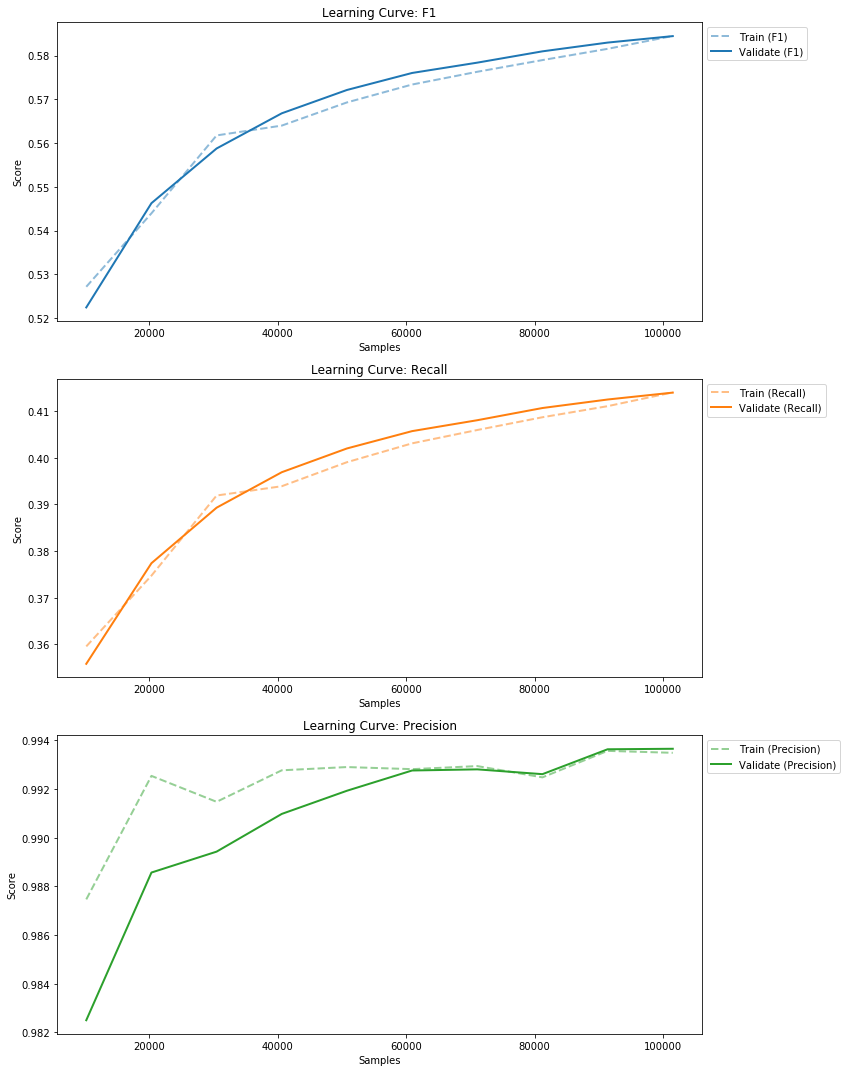

In [306]:
plot_learning_curve(LogisticRegression(), X_train, y_train, scoring=['f1', 'recall','precision'], train_sizes=np.arange(0.1,1.1,0.1), subplots=True, figsize=(10,15), n_jobs=4)

All train and validation scores appear to converge when using our full set of data, with minimal signs of overfitting.

In [135]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [136]:
logreg_train_summary = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              123119                  78
Actual Positive               16863               12214
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.590490
Recall           0.420057
Precision (pos)  0.993654
Precision (neg)  0.879535
Specificity      0.999367
Fallout          0.000633


In [137]:
logreg_test_summary = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               30734                   6
Actual Positive                4213                3116
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.596307
Recall           0.425160
Precision (pos)  0.998078
Precision (neg)  0.879446
Specificity      0.999805
Fallout          0.000195


The models are very precise as there are hardly any false positives. However, recall is in need of improvement since we are only identifying 42% of the actual defaulted loans.

In [138]:
# Add model to list
model = {'model_name': 'LogReg (Basic)',
         'model_type':'LogisticRegression',
         'model': logreg,
         'model_time': logreg_timeit.timings[0],
         'f1_cvs': logreg_f1_cvs,
         'recall_cvs': logreg_recall_cvs,
         'train_summary': logreg_train_summary,
         'test_summary': logreg_test_summary}

models['LogReg (Basic)'] = model

Will attempt to do some basic improvements via hyperparameter tuning with a focus on recall:

In [78]:
scoring=['f1','recall', 'precision']

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': ['balanced', None]}

logreg_gs = GridSearchCV(estimator=LogisticRegression(),
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

t = %timeit -n1 -r1 -o \
logreg_gs.fit(X_train, y_train);

3min 49s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [79]:
def gs_score_summary(gs):
    scores = gs.scoring
    print('-'*20)
    for score in scoring:
        i = np.argmin(gs.cv_results_['rank_test_' + str(score)])
        print('Best {}:'.format(score.title()))
        print('Params: {}'.format(gs.cv_results_['params'][i]))

        for s in scores:
            print('{} = {}'.format(s.title(), gs.cv_results_['mean_test_'+str(s)][i]))
        print('-'*20)

In [80]:
gs_score_summary(logreg_gs)

--------------------
Best F1:
Params: {'C': 1000, 'class_weight': None}
F1 = 0.6147445805141531
Recall = 0.44492224654698764
Precision = 0.9943123314648451
--------------------
Best Recall:
Params: {'C': 0.1, 'class_weight': 'balanced'}
F1 = 0.5558481049810471
Recall = 0.6380988746732669
Precision = 0.4923855075520958
--------------------
Best Precision:
Params: {'C': 1000, 'class_weight': None}
F1 = 0.6147445805141531
Recall = 0.44492224654698764
Precision = 0.9943123314648451
--------------------


Whilst improving recall is our priority, it seems that if we focus solely on maximizing recall score we get a signficantly different set of parameters than the models optimized for f1 and precision. Conversely, the parameters for maximizing f1 seem to do little for improving recall.

We will plot and compare the scores for the values of C for both balanced and non-balanced class weights for additiona insight.

In [173]:
scoring=['f1','recall', 'precision']

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

logreg_C_bal_gs = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

t = %timeit -n1 -r1 -o \
logreg_C_gs.fit(X_train, y_train);

2min 15s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


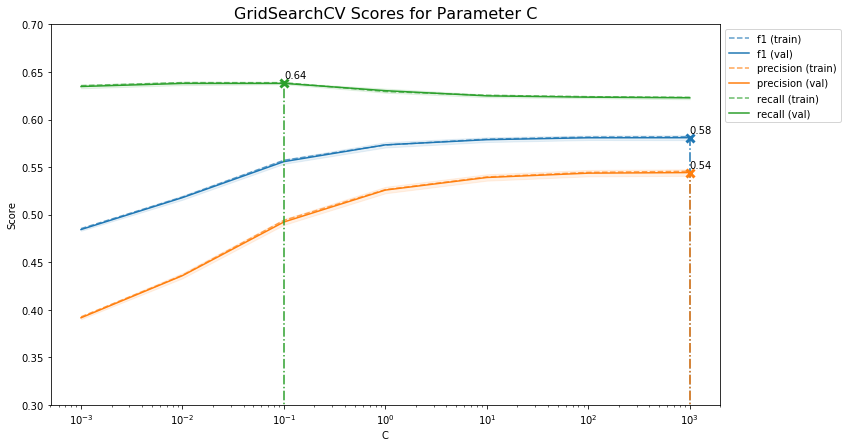

In [193]:
# Balanced weights C plot
plot_gs_param(logreg_C_bal_gs, set_xscale='log', set_ylim=(0.3,0.7), figsize=(12,7))

In [206]:
scoring=['f1','recall', 'precision']

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

logreg_C_gs = GridSearchCV(estimator=LogisticRegression(class_weight=None),
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

t = %timeit -n1 -r1 -o \
logreg_C_gs.fit(X_train, y_train);

2min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


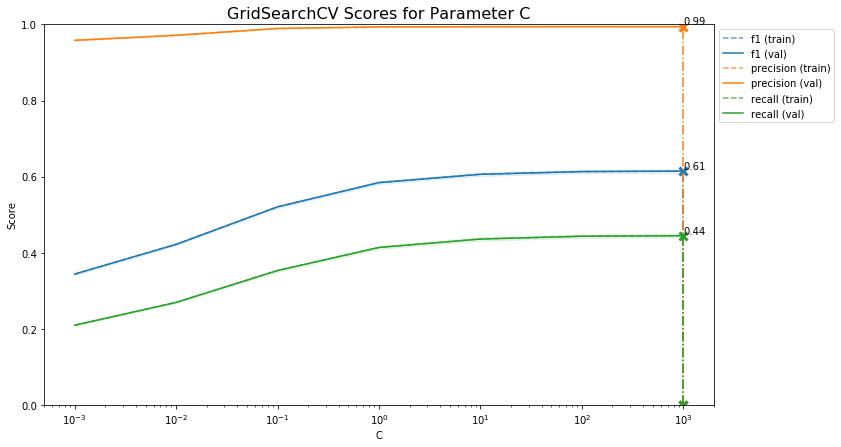

In [210]:
plot_gs_param(logreg_C_gs, set_xscale='log', set_ylim=(0,1), figsize=(12,7))

The balanced class weights has a major impact on our recall, which is expected since our default loans are somewhat of a rare occurance. The non-balanced models are able to achieve such high precision due to the fraction of predicted default loans being relatively small, with the benefit of high certainty. Whilst this certainty is nice, it lets too many default loans slip by. For the sake of a standalone model we should focus on the balanced weights models in the hopes of improving recall. The non-balanced models, however, could still be of use in ensemble methods.

Taking our best result for recall:

In [232]:
logreg_best = LogisticRegression(C=0.1, class_weight='balanced')

In [233]:
logreg_best_f1_cvs = cross_val_score(estimator=logreg_best,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             scoring='f1',
                             n_jobs=4)

In [234]:
logreg_best_r_cvs = cross_val_score(estimator=logreg_best,
                                     X=X_train,
                                     y=y_train,
                                     cv=5,
                                     scoring='recall',
                                     n_jobs=4)

In [235]:
# Test scoring on harsh set
print('CV mean train f1 score = {:.3f}'.format(logreg_best_f1_cvs.mean()))
print('CV mean train recall score = {:.3f}'.format(logreg_best_r_cvs.mean()))

CV mean train f1 score = 0.559
CV mean train recall score = 0.637


Repeat generic scoring for tuned model:

In [236]:
logreg_best_time = %timeit -n1 -r1 -o \
logreg_best.fit(X_train, y_train)

3.64 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [237]:
y_train_pred = logreg_best.predict(X_train)
y_test_pred = logreg_best.predict(X_test)

In [238]:
logreg_best_train_summary = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              104831               18366
Actual Positive               10564               18513
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.561374
Recall           0.636689
Precision (pos)  0.501993
Precision (neg)  0.908454
Specificity      0.850922
Fallout          0.149078


In [239]:
logreg_best_test_summary = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               26775                3965
Actual Positive                2791                4538
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.573269
Recall           0.619184
Precision (pos)  0.533694
Precision (neg)  0.905601
Specificity      0.871015
Fallout          0.128985


Recall appears to have been increased to 0.62 for out test set - an improvement of approx. 0.19 over the basic logistic regression. Specificity and positive precision have obviously suffered as a result, but we are still able retain 87% of the actual negatives with a 90% certainty of said loans not being a default.

In [241]:
# Add model to list
model = {'model_name': 'LogReg (Recall Tuned)',
         'model_type':'LogisticRegression',
         'model': logreg_best,
         'model_time': logreg_best_time.timings[0],
         'f1_cvs': logreg_best_f1_cvs,
         'recall_cvs': logreg_best_r_cvs,
         'train_summary': logreg_best_train_summary,
         'test_summary': logreg_best_test_summary}

models['LogReg (Recall Tuned)'] = model

Taking a look at decision threshold for possible improvements to recall:

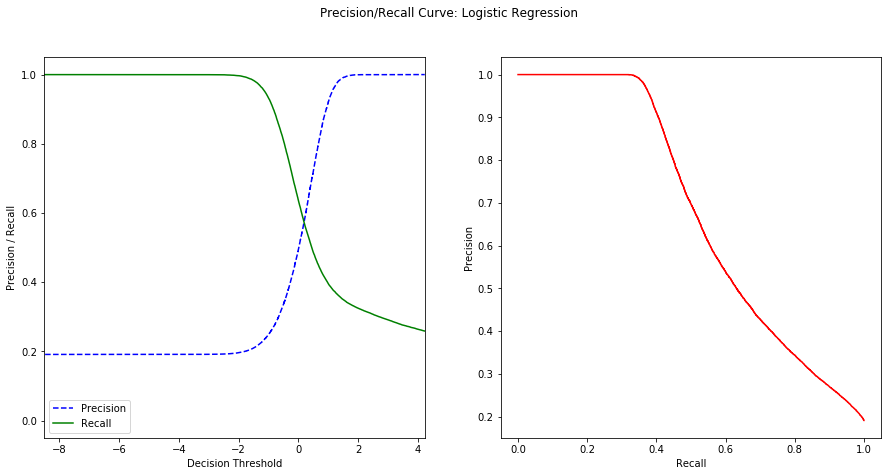

In [242]:
precisions, recalls, thresholds = plot_pr_curve(logreg_best, X_train, y_train, label='Logistic Regression')

We can potentially push recall even higher if we tweak the decision threshold values, for example attempting for a recall of 0.8:

In [245]:
# Get threshold value for desired recall
desired_recall = 0.8
i = len(recalls) - np.argmax(recalls[::-1] > desired_recall) - 1
t = thresholds[i]
print('Threshold for Recall = {}: {:.3f}'.format(desired_recall, t))

Threshold for Recall = 0.8: -0.464


In [248]:
# Filter results based off new threshold
y_train_pred_t = logreg_best.decision_function(X_train) >= t
y_test_pred_t = logreg_best.decision_function(X_test) >= t

In [249]:
classifier_summary(y_train, y_train_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               79951               43246
Actual Positive                5919               23158
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.485081
Recall           0.796437
Precision (pos)  0.348744
Precision (neg)  0.931070
Specificity      0.648969
Fallout          0.351031


In [251]:
classifier_summary(y_test, y_test_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               21057                9683
Actual Positive                1672                5657
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.499096
Recall           0.771865
Precision (pos)  0.368774
Precision (neg)  0.926438
Specificity      0.685003
Fallout          0.314997


Whilst the boosted recall of attainted via this new threshold is a great improvement, it has resulted in a drastically reduced positive precision of 0.34-0.36 and specificity of 0.64-0.68. In other words, only about a third of the actually non-defaulted loans remain, which from a business standpoint is likely too many potential good investments to be discarding.

##### Naive Bayes Classifier

In [263]:
gnb = GaussianNB()

In [268]:
gnb_time = %timeit -n1 -r1 -o \
gnb.fit(X_train, y_train)

187 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [269]:
gnb_f1_cvs = cross_val_score(estimator=gnb, X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=4)

In [270]:
gnb_r_cvs = cross_val_score(estimator=gnb, X=X_train, y=y_train, cv=5, scoring='recall', n_jobs=4)

In [271]:
# Test scoring on harsh set
print('CV mean train f1 score = {:.3f}'.format(gnb_f1_cvs.mean()))
print('CV mean train recall score = {:.3f}'.format(gnb_r_cvs.mean()))

CV mean train f1 score = 0.446
CV mean train recall score = 0.793


In [272]:
y_test_pred = gnb.predict(X_test)
y_train_pred = gnb.predict(X_train)

In [273]:
gnb_train_summary = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               22526              100671
Actual Positive                1162               27915
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.354110
Recall           0.960037
Precision (pos)  0.217092
Precision (neg)  0.950946
Specificity      0.182845
Fallout          0.817155


In [274]:
gnb_test_summary = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  75               30665
Actual Positive                   6                7323
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.323190
Recall           0.999181
Precision (pos)  0.192771
Precision (neg)  0.925926
Specificity      0.002440
Fallout          0.997560


The naive bayes classifier appears to strongly favor our recall score. However, observing the confusion matrix and scores one can note that specificity (number of accurately predicted negatives) suffers greatly. As mentioned earlier, from an investing standpoint, whilst it is important to identify as many default loans as possible, the model is useless if it comes at the cost of removing almost all loans from consideration. Perhaps the size of the training set is causing some these issues:

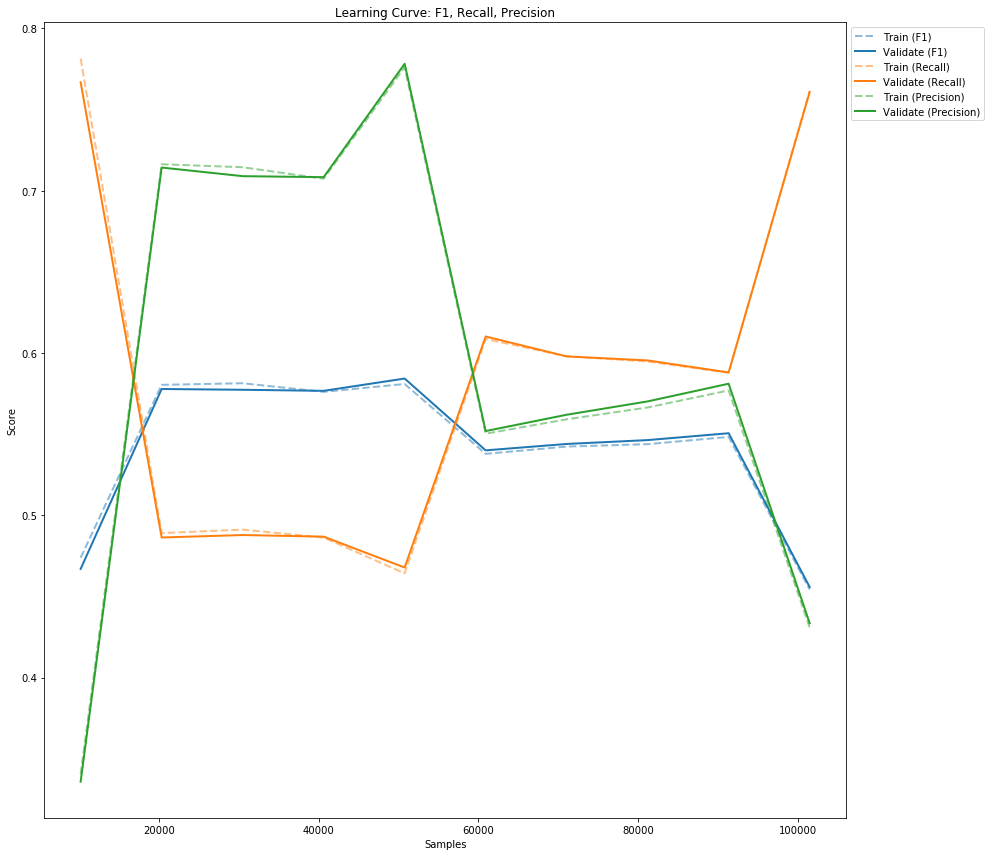

In [307]:
plot_learning_curve(gnb, X_train, y_train, scoring=['f1', 'recall','precision'], train_sizes=np.arange(0.1,1.01,0.1), subplots=False, figsize=(12,12), n_jobs=4)

It would appear that in terms of precision and f1 scores, once we start utilizing 60,0000+ records for modelling the definition of a default loans becomes blurred. This would explain the high recall and large number of predicted positives (default loans). Consequently, modelling off of smaller batches of data may prove more balanced in terms of an acceptable recall and precision combination.

In [275]:
# Add model to dict
model = {'model_name': 'Naive Bayes (Basic)',
         'model_type':'GassianNB',
         'model': gnb,
         'model_time': gnb_time.timings[0],
         'f1_cvs': gnb_f1_cvs,
         'recall_cvs': gnb_r_cvs,
         'train_summary': gnb_train_summary,
         'test_summary': gnb_test_summary}

models['Naive Bayes (Basic)'] = model

Although nothing can be done in the way of parameter tuning, we will see what additional improvements can be made by modifying the decision boundary:

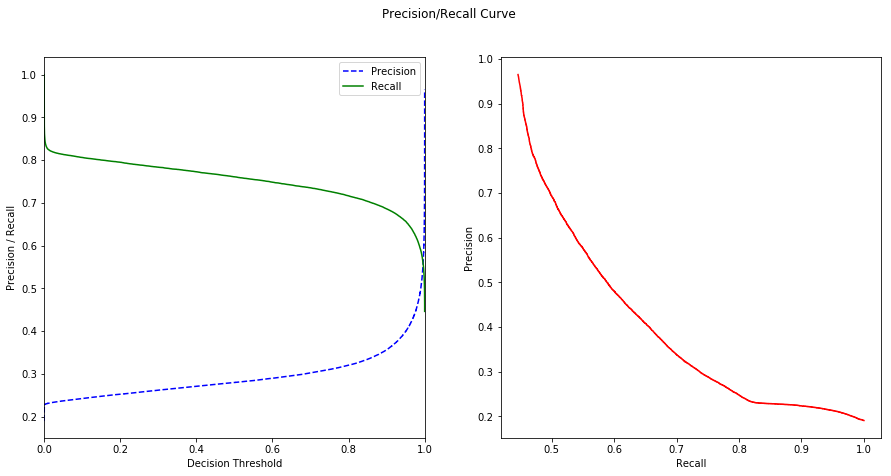

In [276]:
precisions, recalls, thresholds = plot_pr_curve(gnb, X_train, y_train)

We will reduce recall in hopes of acheiving a better balance in scores:

In [277]:
# Get threshold value for desired recall
desired_recall = 0.7
i = len(recalls) - np.argmax(recalls[::-1] > desired_recall) - 1
t = thresholds[i]
t

0.86140530810699245

In [278]:
y_train_pred_t = gnb.predict_proba(X_train)[:,1] >= t 

In [279]:
cmat, scores = classifier_summary(y_train, y_train_pred_t)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               56062               67135
Actual Positive                3691               25386
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.417540
Recall           0.873061
Precision (pos)  0.274381
Precision (neg)  0.938229
Specificity      0.455060
Fallout          0.544940


Significantly increasing the threshold to acheive an approximate recall of 0.7, we can acheive signficiant improvements in all other scores. If this model were to be ultimately be used, some fine tuning of this threshold would be required.

##### KNN

KNN will likely take a while to compute due to the $O(kn \times mn)$ complexity, but we will still give it a try and see how it performs.

In [16]:
knn = Pipeline([('norm', Normalizer()),
                ('estimator', KNeighborsClassifier())])

In [17]:
knn_time = %timeit -n1 -r1 -o \
knn.fit(X_train, y_train)

1.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Significantly longer than most of what we have seen so far - as expected. Cross validation scores will take a while to process but still worthwhile:

In [297]:
knn_f1_cvs = cross_val_score(estimator=knn, X=X_train, y=y_train, cv=3, scoring='f1', n_jobs=4)

In [299]:
knn_r_cvs = cross_val_score(estimator=knn, X=X_train, y=y_train, cv=3, scoring='recall', n_jobs=4)

In [300]:
print('CV mean train f1 score = {:.3f}'.format(knn_f1_cvs.mean()))
print('CV mean train recall score = {:.3f}'.format(knn_r_cvs.mean()))

CV mean train f1 score = 0.344
CV mean train recall score = 0.247


Already looking to be significantly worse than the other models tested until now, but this could also be a result of the fold sample sizes not providing sufficient information. Predictions using KNN are also likely to take some time due to its nature of having to process the entire set each time:

In [285]:
%timeit -n1 -r1 \
y_train_pred = knn.predict(X_train)

6min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [288]:
%timeit -n1 -r1 \
y_test_pred = knn.predict(X_test)

1min 51s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Due to the nature of KNN these predictions took signficantly longer for predictions than our other models thus far.

In [301]:
knn_train_summary = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               22526              100671
Actual Positive                1162               27915
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.354110
Recall           0.960037
Precision (pos)  0.217092
Precision (neg)  0.950946
Specificity      0.182845
Fallout          0.817155


In [302]:
knn_test_summary = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  75               30665
Actual Positive                   6                7323
--------------------
Accuracy Scores:
                    Score
Rate                     
f1               0.323190
Recall           0.999181
Precision (pos)  0.192771
Precision (neg)  0.925926
Specificity      0.002440
Fallout          0.997560


We appear to be getting very similar results to our Naive Bayes classifier, and are probably seeing the same issues arising as a result of the large training set size:

In [ ]:
plot_learning_curve(knn, X_train, y_train, scoring=['f1', 'recall','precision'], train_sizes=[0.3,0.5,0.7], cv=3, subplots=False, figsize=(12,12), n_jobs=4)

##### Support Vector Classifier

Support Vector Classifiers are likely to be computationally expensive due to the number of features, but we will still give it a try and see how it performs.

In [146]:
lin_svc = LinearSVC()

In [147]:
lin_svc_time = %timeit -n1 -r1 -o \
lin_svc.fit(X_train, y_train)

30.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Somewhat slower due to large number of training instances n (160k) and features m (59). (complexity $O(m\times n)$)

In [52]:
lin_svc_f1_cvs = cross_val_score(estimator=LinearSVC(), X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=4)

In [53]:
lin_svc_r_cvs = cross_val_score(estimator=LinearSVC(), X=X_train, y=y_train, cv=5, scoring='recall', n_jobs=4)

In [55]:
print('CV mean train f1 score = {:.3f}'.format(lin_svc_f1_cvs.mean()))
print('CV mean train recall score = {:.3f}'.format(lin_svc_r_cvs.mean()))

CV mean train f1 score = 0.606
CV mean train recall score = 0.434


Comparable results to our base logistic regression model, with slight improvements to both f1 and recall scores.

In [148]:
y_train_pred = lin_svc.predict(X_train)
y_test_pred = lin_svc.predict(X_test)

In [149]:
lin_svc_train_summary = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              123197                   0
Actual Positive               16403               12674
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.607123
Recall       0.435877
Precision    1.000000
Specificity  1.000000
Fallout      0.000000


In [150]:
lin_svc_test_summary = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               30740                   0
Actual Positive                4109                3220
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.610484
Recall       0.439351
Precision    1.000000
Specificity  1.000000
Fallout      0.000000


The base model clearly favors precision and specificity - in fact in both train and test predictions there is not a single false positive. Recall on the other hand is still in the low 0.4 range, so we will see what improvements can be made via parameter tuning.

In [443]:
# Add model to list
model = {'model_name': 'Linear SVC (Basic)',
         'model_type':'LinearSVC',
         'model': lin_svc,
         'train_score': train_score,
         'test_score': test_score}

models.append(model)

Will see if grid search is feasible for hyperparameter tuning based off recall score:

In [132]:
param_grid = {'C': [.001, .01, .1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', None]}

lsvc_gs = GridSearchCV(estimator=LinearSVC(dual=False),
                       param_grid=param_grid,
                       scoring=['f1', 'recall'],
                       refit='recall',
                       cv=3,
                       n_jobs=4)

lsvc_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score=True,
       scoring=['f1', 'recall'], verbose=0)

In [133]:
lsvc_gs.best_score_

0.6272999631246251

In [134]:
lsvc_gs.best_params_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}

In [135]:
lsvc_best = lsvc_gs.best_estimator_

In [136]:
y_train_pred = lsvc_best.predict(X_train)
y_test_pred = lsvc_best.predict(X_test)

In [137]:
lsvc_train_summary = classifier_summary(y_train, y_train_pred);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              105423               17774
Actual Positive               10887               18190
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.559339
Recall       0.625580
Precision    0.505784
Specificity  0.855727
Fallout      0.144273


In [138]:
lsvc_test_summary = classifier_summary(y_test, y_test_pred);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               26967                3773
Actual Positive                2868                4461
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.573283
Recall       0.608678
Precision    0.541778
Specificity  0.877261
Fallout      0.122739


The optimized linear SVC seems to acheive similar results to logistic regression with a recall of 0.6, but we have obviously lost our perfect precision.

In [440]:
# Add model to list
model = {'model_name': 'Linear SVC (Tuned)',
         'model_type':'LinearSVC',
         'model': lsvc_best,
         'train_score': train_scores.iloc[0,0],
         'test_score': test_scores.iloc[0,0]}

models.append(model)

Exploring this tradeoff further may lead to a better model for our purposes (i.e. higher recall vs. precision), with adjustmenets to the decision threshold:

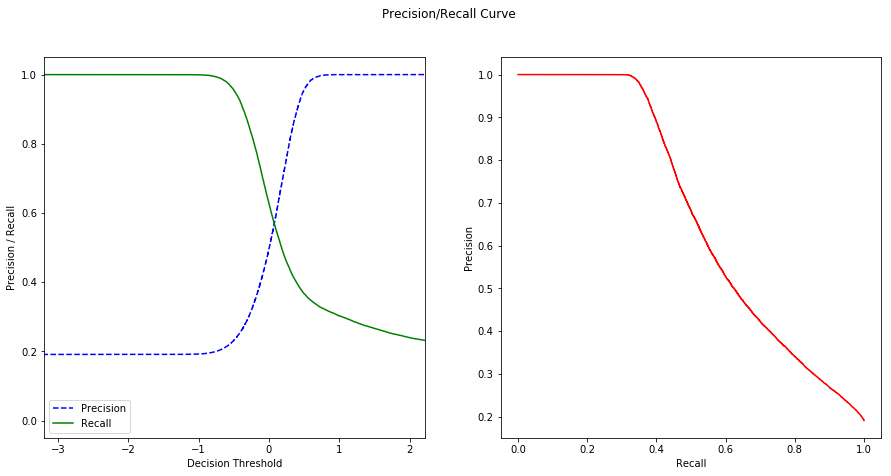

In [151]:
precisions, recalls, thresholds = plot_pr_curve(lsvc_best, X_train, y_train)

In [158]:
# Filter off new threshold
y_train_pred_t = lsvc_best.decision_function(X_train) > -.5

In [159]:
classifier_summary(y_train, y_train_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               32138               91059
Actual Positive                1353               27724
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.375003
Recall       0.953468
Precision    0.233400
Specificity  0.260867
Fallout      0.739133


Reducing the threshold greatly improves recall, but again at at a considerable cost to precision and specificity, with only a little over 25% of the non-defaulted loans remaining.

##### Support Vector Classifier - Polynomial

In [17]:
psvc = SVC(kernel='poly', degree=2)

In [ ]:
psvc_time = %timeit -n1 -r1 -o \
psvc.fit(X_train, y_train)

##### Support Vector Classifier  - RBF

In [160]:
rsvc = SVC(kernel='rbf')

In [ ]:
rsvc_time = %timeit -n1 -r1 -o \
rsvc.fit(X_train, y_train)

##### Decision Tree Classifier

In [51]:
dtc = DecisionTreeClassifier()

In [61]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

In [55]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167722                   0
Actual Positive                   0               37806
--------------------
Accuracy Scores:
             Score
Rate              
f1             1.0
Recall         1.0
Precision      1.0
Specificity    1.0
Fallout        0.0


In [56]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               37437                4526
Actual Positive                3950                5469
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.563408
Recall       0.580635
Precision    0.547174
Specificity  0.904559
Fallout      0.095441


Here we have a classic example of overfitting. The decision tree clearly needs to be constrained with some of its parameters to limit the depth and number of splits/leaves in the tree.

In [ ]:
# Add model to list
model = {'model_name': 'Decision Tree (Basic)',
         'model_type':'DecisionTreeClassifier',
         'model': dtc,
         'train_score': train_scores.iloc[0,0],
         'test_score': test_scores.iloc[0,0]}

models.append(model)

Due to the variety of parameter values, randomized search will be done in place of grid search:

In [69]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': np.arange(10,100,5),
              'min_samples_split': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'min_samples_leaf': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'max_features': np.append(np.array(['sqrt', 'log2', None]), np.arange(0.1,1,0.1)).astype('object')}

dtc_rs = RandomizedSearchCV(estimator=dtc,
                  param_distributions = param_grid,
                  n_iter=100,
                  scoring='f1',
                  cv=3,
                  n_jobs=-1)

dtc_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
       95]), 'min_samples_split': array([  2,   3,   4,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,
        55,  60,  65,  70,  75,  80,  85,  90,  95,..., 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
       0.7000000000000001, 0.8, 0.9], dtype=object)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring

In [70]:
dtc_rs.best_params_

{'criterion': 'entropy',
 'max_depth': 55,
 'max_features': 0.7000000000000001,
 'min_samples_leaf': 80,
 'min_samples_split': 20}

In [71]:
dtc_rs.best_score_

0.66669749055934557

In [72]:
dtc_best = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=55,
                                  max_features=0.7,
                                  min_samples_leaf=80,
                                  min_samples_split=20)

In [73]:
dtc_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=55,
            max_features=0.7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=80, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [75]:
y_train_pred = dtc_best.predict(X_train)
y_test_pred = dtc_best.predict(X_test)

In [76]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167589                 133
Actual Positive               18804               19002
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.667428
Recall       0.502619
Precision    0.993049
Specificity  0.899116
Fallout      0.100884


In [77]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               41921                  42
Actual Positive                4733                4686
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.662473
Recall       0.497505
Precision    0.991117
Specificity  0.898551
Fallout      0.101449


Although our parameter tuning improved overall f1 scores, it actually wound up hurting our recall, specificity, and fallout in order to acheive higher precision, which is the score we are least concerned with. We will try optimizing parameters with respect to the recall score:

In [79]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': np.arange(10,100,5),
              'min_samples_split': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'min_samples_leaf': np.append(np.array([2,3,4]), np.arange(5,101,5)),
              'max_features': np.append(np.array(['sqrt', 'log2', None]), np.arange(0.1,1,0.1)).astype('object')}

dtc_rs_2 = RandomizedSearchCV(estimator=dtc,
                  param_distributions = param_grid,
                  n_iter=100,
                  scoring='recall',
                  cv=3,
                  n_jobs=-1)

dtc_rs_2.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,
       95]), 'min_samples_split': array([  2,   3,   4,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,
        55,  60,  65,  70,  75,  80,  85,  90,  95,..., 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
       0.7000000000000001, 0.8, 0.9], dtype=object)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring

In [80]:
dtc_rs_2.best_params_

{'criterion': 'entropy',
 'max_depth': 60,
 'max_features': 0.8,
 'min_samples_leaf': 5,
 'min_samples_split': 15}

In [81]:
dtc_rs_2.best_score_

0.56800507971723146

In [102]:
dtc_best = dtc_rs_2.best_estimator_

In [103]:
dtc_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=60,
            max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [104]:
y_train_pred = dtc_best.predict(X_train)
y_test_pred = dtc_best.predict(X_test)

In [105]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              163673                4049
Actual Positive                8725               29081
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.819922
Recall       0.769217
Precision    0.877784
Specificity  0.949390
Fallout      0.050610


In [106]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               38937                3026
Actual Positive                4130                5289
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.596481
Recall       0.561525
Precision    0.636079
Specificity  0.904103
Fallout      0.095897


Whilst there is some improvement in recall, it seems that this model still suffers from overfitting when trying to maximize recall. Acheiving a better balance between overfitting and recall will likely require more extensive parameter tweaking and feature optimization beyond the scope of this MVP. For the sake of this analysis, perhaps a random forest classifier will provide a more immediate improvement.

##### Random Forest Classifier

In [107]:
rfc = RandomForestClassifier(n_estimators=20,
                             criterion='entropy',
                             max_features=0.8,
                             max_depth=60,
                             min_samples_split=5,
                             min_samples_leaf=15,
                             n_jobs=-1)

In [108]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=60, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

In [110]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              167710                  12
Actual Positive               18456               19350
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.676952
Recall       0.511824
Precision    0.999380
Specificity  0.900863
Fallout      0.099137


In [111]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               41934                  29
Actual Positive                4749                4670
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.661567
Recall       0.495806
Precision    0.993828
Specificity  0.898271
Fallout      0.101729


In [112]:
param_grid = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy'],
              'class_weight': ['balanced', None],
              'max_features': np.arange(.5,.91,0.1),
              'max_depth': np.arange(20,60,5),
              'min_samples_split': np.arange(20,101,5),
              'min_samples_leaf': np.arange(50,101,5)}

rfc_rs = RandomizedSearchCV(estimator=rfc,
                  param_distributions = param_grid,
                  n_iter=50,
                  scoring='recall',
                  cv=3,
                  n_jobs=-1)

rfc_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=60, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None], 'max_features': array([ 0.5 ,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,  0.57,  0.58,
        0.59,  0.6 ,  0.61,  0.62,  0.63,  0.64,  0.65,  0.66,  0.67,
        0.68,  0.69,  0.7... 90,  95, 100]), 'min_samples_leaf': array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100])},
          pre_dispatch='2*n_jobs', ran

In [113]:
rfc_rs.best_params_

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 27,
 'max_features': 0.96000000000000041,
 'min_samples_leaf': 90,
 'min_samples_split': 40}

In [114]:
rfc_rs.best_score_

0.65225099106591289

In [131]:
rfc_best = RandomForestClassifier(n_estimators=20,
                                  bootstrap=False,
                                  class_weight='balanced',
                                  criterion='entropy',
                                  max_depth=25,
                                  max_features=0.9,
                                  min_samples_leaf=90,
                                  min_samples_split=40,
                                  n_jobs=-1)

In [132]:
rfc_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=25, max_features=0.9,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=90,
            min_samples_split=40, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [133]:
y_train_pred = rfc_best.predict(X_train)
y_test_pred = rfc_best.predict(X_test)

In [134]:
train_cmat, train_scores = classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              152386               15336
Actual Positive               10557               27249
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.677912
Recall       0.720759
Precision    0.639873
Specificity  0.935210
Fallout      0.064790


In [135]:
test_cmat, test_scores = classifier_summary(y_test, y_test_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               37587                4376
Actual Positive                3375                6044
--------------------
Accuracy Scores:
                Score
Rate                 
f1           0.609305
Recall       0.641682
Precision    0.580038
Specificity  0.917607
Fallout      0.082393
